In [152]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame
import random
import operator
import datetime

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn import datasets, linear_model, cross_validation, grid_search, svm, ensemble, kernel_ridge
import xgboost as xgb

In [153]:
np.random.seed(10)
random.seed(10)

In [154]:
def rmspe(y, yhat):
    y = y.astype('float')
    yhat = yhat.astype('float')
    inner = ((y-yhat)/y)**2
    return (np.mean(inner))**0.5

In [155]:
# get rossmann, store, & test csv files as a DataFrame
train_df  = pd.read_csv("../input/train.csv")
store_df     = pd.read_csv("../input/store.csv")
test_df      = pd.read_csv("../input/test.csv")

### Data Preprocessing ###

In [156]:
# Got a warning about column 7 during import.
# Fix it by change all 0 to '0'
train_df.loc[train_df['StateHoliday'] == 0, 'StateHoliday'] = '0'

# Convert the date column in train and test data
train_df['Date'] = pd.to_datetime(train_df['Date'], format="%Y-%m-%d")
test_df['Date'] = pd.to_datetime(test_df['Date'], format="%Y-%m-%d")

# Keep only records where the store is open
train_df = train_df[train_df['Open'] == 1]

# Keep only records with non-zero sales
train_df = train_df[train_df['Sales'] > 0]

for i in range(1,13):
    month = datetime.date(2008, i, 1).strftime('%b')
    store_df['Promo2_' + str(i)] = store_df['Promo2'] * store_df['PromoInterval'].apply(lambda x: month in str(x))

# !!!!!!!
train_df.drop('StateHoliday', inplace=True, axis=1)
train_df.drop('SchoolHoliday', inplace=True, axis=1)
test_df.drop('StateHoliday', inplace=True, axis=1)
test_df.drop('SchoolHoliday', inplace=True, axis=1)


In [157]:
def convertColToCategory(data, colName, knownCategories):
    data.loc[:, colName] = data.loc[:, colName].astype('category', categories=knownCategories)

def transformData(inputData):

    data = inputData.copy()
    startDate = train_df['Date'].min()

    # StateHoliday have values of both '0' and 0.  Change all 0 to '0'
    #data.loc[data['StateHoliday'] == 0, ('StateHoliday')] = '0'

    #data.loc[:, ('daysSince')] = data['Date'].apply(lambda d: (d - startDate).days)
    data.loc[:, ('Month')] = data['Date'].apply(lambda d: d.month)
    data.loc[:, ('Year')] = data['Date'].apply(lambda d: d.year)
    
    # Convert categorical columns to category type
    convertColToCategory(data, 'DayOfWeek', range(1, 8))
    convertColToCategory(data, 'Month', range(1, 13))
    convertColToCategory(data, 'Year', range(2013, 2016))
    convertColToCategory(data, 'Promo', range(2))
    #convertColToCategory(data, 'SchoolHoliday', range(2))
    #convertColToCategory(data, 'StateHoliday', list('0abc'))
    
    
    #if 'StoreType' in data.columns:
    #    convertColToCategory(data, 'StoreType', list('abcd'))
                         
    #if 'Assortment' in data.columns:
    #    convertColToCategory(data, 'Assortment', list('abc'))

    return pd.get_dummies(data)

In [158]:
store_cols = [i for i in store_df.columns.tolist() if 'Promo2_' in i]
store_cols.append('Store')

train_full_df = pd.merge(train_df, store_df.ix[:,store_cols], on='Store')
#train_full_df = train_df
train_data = transformData(train_full_df)

train_data.set_index('Date', inplace=True)
train_data.sort_index(inplace=True)

test_full_df = pd.merge(test_df, store_df.ix[:,store_cols], on='Store')
#test_full_df = test_df
test_data = transformData(test_full_df)

In [159]:
train_data.columns


Index([u'Store', u'Sales', u'Customers', u'Open', u'Promo2_1', u'Promo2_2',
       u'Promo2_3', u'Promo2_4', u'Promo2_5', u'Promo2_6', u'Promo2_7',
       u'Promo2_8', u'Promo2_9', u'Promo2_10', u'Promo2_11', u'Promo2_12',
       u'DayOfWeek_1', u'DayOfWeek_2', u'DayOfWeek_3', u'DayOfWeek_4',
       u'DayOfWeek_5', u'DayOfWeek_6', u'DayOfWeek_7', u'Promo_0', u'Promo_1',
       u'Month_1', u'Month_2', u'Month_3', u'Month_4', u'Month_5', u'Month_6',
       u'Month_7', u'Month_8', u'Month_9', u'Month_10', u'Month_11',
       u'Month_12', u'Year_2013', u'Year_2014', u'Year_2015'],
      dtype='object')

In [160]:
x_drop_cols = ['Store', 'Sales', 'Customers', 'Open']
promo_cols = [i for i in store_df.columns.tolist() if 'Promo2_' in i]

def trainModels(algo, fitOnly=False, store=None, includePromo=False, **kwargs):
    all_y = []
    all_yhat = []
    all_rmspe = {}
    models = {}
    stores_not_in_dev_set = []
    
    cols_to_drop = list(x_drop_cols)
    if not includePromo:
        cols_to_drop.extend(promo_cols)
    
    if store is not None:
        data = train_data[train_data['Store'] == store]
    else:
        data = train_data
    
    if fitOnly:
        train_set = data
        dev_set = []
    else:
        test_cutoff_date = data.index.max() - pd.DateOffset(months = 2)
        train_set = data[data.index <= test_cutoff_date]        
        dev_set = data[data.index > test_cutoff_date]

        # use Aug/Sep 2014 as dev set
        #cutoff_head = pd.tslib.Timestamp(np.datetime64('2014-08-01'))
        #cutoff_tail = pd.tslib.Timestamp(np.datetime64('2014-09-17'))
        #train_set = data[np.logical_or(data.index < cutoff_head, data.index > cutoff_tail)]       
        #dev_set = data[np.logical_and(data.index >= cutoff_head, data.index <= cutoff_tail)]
        
    print "train_set size:", len(train_set)
    print "dev_set size:", len(dev_set)
    if len(dev_set) > 0:
        print "dev set: min=%s, max=%s" % (str(dev_set.index.min()), str(dev_set.index.max()) )
    
    train_set_grouped = train_set.groupby('Store')
    
    if not fitOnly:
        dev_set_grouped = dev_set.groupby('Store')

    for group in train_set_grouped.groups:        
        train_X = train_set_grouped.get_group(group).drop(cols_to_drop, axis=1, inplace=False)
        train_y = np.log(train_set_grouped.get_group(group)['Sales'])

        # One model per store
        if algo == 'lr':
            model = linear_model.LinearRegression(**kwargs)
        elif algo == 'ridge':
            model = linear_model.Ridge(**kwargs)
        elif algo == 'svr':
            model = svm.SVR(**kwargs)
        elif algo == 'nsvr':
            model = svm.NuSVR(**kwargs)
        elif algo == 'rfr':
            model = ensemble.RandomForestRegressor(**kwargs)
        elif algo == 'kr':
            model = kernel_ridge.KernelRidge(**kwargs)
        elif algo == 'xgb':
            model = xgb.XGBRegressor(**kwargs)
            
        model.fit(X=train_X, y=train_y)
        models[group] = model
        
        if not fitOnly:
            # Temp
            if group in dev_set_grouped.groups:
            
                dev_X = dev_set_grouped.get_group(group).drop(cols_to_drop, axis=1, inplace=False)
                dev_y = np.log(dev_set_grouped.get_group(group)['Sales'])
                yhat = model.predict(dev_X)

                all_y.extend(dev_y.tolist())
                all_yhat.extend(yhat.tolist())

                all_rmspe[group] = rmspe(np.exp(np.array(dev_y.tolist())), np.exp(yhat))
            else:
                stores_not_in_dev_set.append(group)

    if not fitOnly:
        print "Training model - dev data RMSPE=", rmspe(np.exp(np.array(all_y)), np.exp(np.array(all_yhat)))
        
    print "Model:\n", models[data.iloc[0]['Store']]
    if len(stores_not_in_dev_set) > 0:
        print "\nStores not in dev set: ", stores_not_in_dev_set
    
    return all_rmspe, models



def displayRmspes(rmspes):
    sorted_x = sorted(rmspes.items(), key=operator.itemgetter(1))
    print "Best 10:\n"
    print sorted_x[:10]
    print "\bWorst 10:\n"
    print sorted_x[-10:]
    
def plotResult(models, store, rmspes, dateRange=None):
    fig, axis = plt.subplots(figsize=(15,4))
    data = train_data[train_data['Store'] == store]
    
    if dateRange is not None:
        head = pd.tslib.Timestamp(np.datetime64(dateRange[0]))
        tail = pd.tslib.Timestamp(np.datetime64(dateRange[1]))
        data = data[np.logical_and(data.index >= head, data.index <= tail)]        
    
    yhat = models[store].predict(data.drop(x_drop_cols, axis=1, inplace=False))
    axis.plot(data.index.tolist(), np.log(data['Sales']).tolist(), marker='.',
         color='b', linestyle='None', alpha=0.5)
    axis.plot(data.index.tolist(), yhat.tolist(), marker='.',
     color='r', linestyle='None', alpha=0.5)
    axis.set_title('Store = %s; rmspe = %f' % (str(store), rmspes[store]))

In [161]:
storeid = None
includePromo = True

In [162]:
rmspes, models = trainModels('lr', storeid, includePromo = includePromo)

train_set size: 785727
dev_set size: 58611
dev set: min=2015-06-01 00:00:00, max=2015-07-31 00:00:00
Training model - dev data RMSPE= 0.141174121055
Model:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [163]:
#rmspes, models = trainModels('svr', store=None, includePromo = includePromo, cache_size=900)

In [164]:
rmspes, models = trainModels('nsvr', store=None, includePromo = includePromo, cache_size=900, nu=0.8, C=1.0)


train_set size: 785727
dev_set size: 58611
dev set: min=2015-06-01 00:00:00, max=2015-07-31 00:00:00
Training model - dev data RMSPE= 0.126791703666
Model:
NuSVR(C=1.0, cache_size=900, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.8, shrinking=True, tol=0.001, verbose=False)


In [165]:
displayRmspes(rmspes)

#sorted_x = sorted(rmspes.items(), key=operator.itemgetter(1))
#[x[0] for x in sorted_x[-10:]]

Best 10:

[(974, 0.066575251553563336), (523, 0.067665716164997031), (783, 0.069702107525504681), (423, 0.070379823636023395), (1080, 0.07083914957418605), (562, 0.072060871436608345), (245, 0.072377612262845517), (260, 0.073779539848055825), (498, 0.074046834651123022), (613, 0.074508662199322326)]
Worst 10:

[(1039, 0.3066301857439423), (550, 0.32066377662593959), (711, 0.3386872723853448), (876, 0.35749741128836837), (286, 0.36000129265894348), (770, 0.36206801037223341), (782, 0.48332450783742814), (909, 0.56172182295427653), (415, 0.73839651222256186), (292, 0.73980893701236061)]


(array([  34.,  153.,  310.,  261.,  151.,   79.,   40.,   22.,   17.,
          12.,    6.,    7.,    4.,    2.,    3.,    2.,    1.,    2.,
           1.,    0.,    1.,    3.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    2.]),
 array([ 0.06657525,  0.08003993,  0.0935046 ,  0.10696927,  0.12043395,
         0.13389862,  0.14736329,  0.16082797,  0.17429264,  0.18775731,
         0.20122199,  0.21468666,  0.22815134,  0.24161601,  0.25508068,
         0.26854536,  0.28201003,  0.2954747 ,  0.30893938,  0.32240405,
         0.33586873,  0.3493334 ,  0.36279807,  0.37626275,  0.38972742,
         0.40319209,  0.41665677,  0.43012144,  0.44358612,  0.45705079,
         0.47051546,  0.48398014,  0.49744481,  0.51090948,  0.52437416,
         0.53783883,  0.55130351,  0.56476818,  0.57823285,  0.59169753,
         0.60516

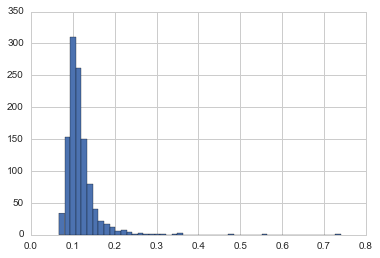

In [166]:
plt.hist(rmspes.values(), bins=50)

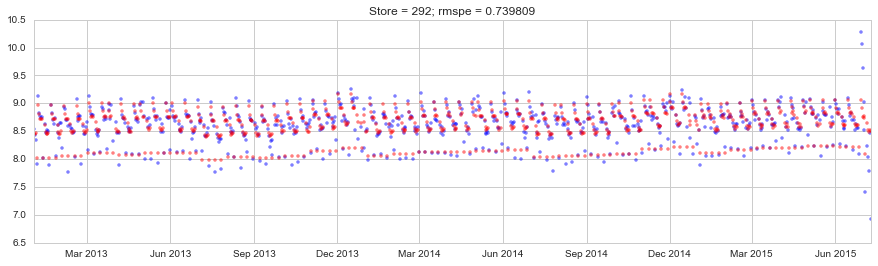

In [168]:
#plotResult(models, 292, rmspes, ['2013-07-01', '2013-09-30'])
#plotResult(models, 292, rmspes, ['2014-07-01', '2014-09-30'])
plotResult(models, 292, rmspes)


In [142]:
rmspes, models = trainModels('nsvr', fitOnly=True, store=None, includePromo = includePromo, cache_size=900, nu=0.8)

train_set size: 844338
dev_set size: 0
Model:
NuSVR(C=1.0, cache_size=900, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.8, shrinking=True, tol=0.001, verbose=False)


In [ ]:
#rmspes, models = trainModels('rfr', n_jobs=-1, n_estimators=100)

In [ ]:
#rmspes, models = trainModels('kr')


## Make Predictions on Test data ##

In [143]:
def makePredictions(data, includePromo = False):
    test_ids = []
    test_yhats = []

    grouped = data.groupby('Store')

    cols_to_drop = list(['Id', 'Date', 'Store', 'Open'])
    if not includePromo:
        cols_to_drop.extend(promo_cols)    

    for storeId, group in grouped:
        ids = group['Id']
        X = group.drop(cols_to_drop, axis=1, inplace=False)

        yhat = np.exp(models[storeId].predict(X))

        # Ignore prediction and set Sales to zero hen the store is closed
        yhat[np.array(group['Open'] == 0)] = 0
        test_yhats += yhat.tolist()
        test_ids += ids.tolist()

    res = [[i, y] for i, y in zip(test_ids, test_yhats)]
    return sorted(res, key=lambda x: x[0])

In [144]:
result = makePredictions(test_data, includePromo = includePromo)

In [145]:
f = open("submission.csv", "w")
f.write('"Id","Sales"\n')

for r in result:
    f.write("%d,%d\n" % (r[0],int(r[1])))
    
f.close()


In [146]:
# Quick check to make sure the file isn't corrupted.
df = pd.read_csv('submission.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 2 columns):
Id       41088 non-null int64
Sales    41088 non-null int64
dtypes: int64(2)
memory usage: 963.0 KB


#### Misc stuff ####

In [545]:
def littleTest(includePromo):
    # Test prediction using some input generated from training data
    random_idx = random.sample(train_df.index.tolist(), 100)

    try_df = train_df.loc[random_idx]
    try_y = try_df['Sales']
    try_df.drop(['Sales', 'Customers'], axis=1, inplace=True)
    try_df["Id"] = range(1, len(try_df) + 1)
    try_data = transformData(pd.merge(try_df, store_df.ix[:,store_cols], on='Store'))
    #try_data = transformData(try_df)

    result = makePredictions(try_data, includePromo )
    try_yhat = np.array([r[1] for r in result])

    print rmspe(try_y, try_yhat)

In [546]:
littleTest(includePromo)

0.11283791086
